In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import math
import torch
import torch.nn as nn
import random

from IPython.display import Image
from pathlib import Path
from tqdm import tqdm

from src.models.vae import VAE
from src.const import DATA_PATH, SEED
from src.preprocess import get_data_loader
from src.models.utils import pos_encoding

BATCH_SIZE = 32

/home/telejkoi/anaconda3/envs/dl2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
vae = VAE(device)
train_dataloader = get_data_loader(DATA_PATH, BATCH_SIZE, vae=None, n=20000)

for idx, batch in enumerate(train_dataloader):
    break

/home/telejkoi/anaconda3/envs/dl2/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
batch[0].cpu().numpy().min(), batch[0].cpu().numpy().max()

(0.0, 1.0)

In [44]:
class EmbeddingBlock(nn.Module):
    """Embedding block for UNet."""

    def __init__(self, n_steps, d_model):
        super(EmbeddingBlock, self).__init__()
        self.n_steps = n_steps
        # self.t_embed = self.init_pos_encoding(d_model)
        # self.l1 = nn.Linear(16, 32)
        # self.l2 = nn.Linear(32, d_model)
        # self.silu = nn.SiLU()

    def init_pos_encoding(self):
        t_embed = nn.Embedding(self.n_steps, self.d_model)
        t_embed.weight.data = pos_encoding(self.n_steps, self.d_model)
        t_embed.requires_grad = False
        return t_embed

    def forward(self, t):
        t = self.t_embed(t)
        # t = self.l1(t)
        # t = self.silu(t)
        # t = self.l2(t)
        return t

class ConvBlock(nn.Module):
    """Convolutional block for UNet."""

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding="same")
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding="same")
        self.relu = nn.ReLU()
        self.bnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bnorm(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bnorm(x)
        x = self.relu(x)
        return x

class DownsampleBlock(nn.Module):
    """Downsample block block for UNet."""

    def __init__(self, in_channels, out_channels):
        super(DownsampleBlock, self).__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = self.conv(x)
        pool = self.pool(x)
        return x, pool

class UpsampleBlock(nn.Module):
    """Upsample block for UNet."""

    def __init__(self, in_channels, out_channels):
        super(UpsampleBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)
        self.conv = ConvBlock(2*out_channels, out_channels)

    def forward(self, x, down_tensor):
        x = self.upconv(x)
        x = torch.cat((x, down_tensor), dim=1)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    """UNet model for diffusion."""

    def __init__(self, batch_size, n_steps, input_size=32, in_channels=4, first_layer_channels=64):
        super(UNet, self).__init__()

        self.batch_size = batch_size

        # input size
        self.s1 = input_size
        self.s2 = self.s1 // 2
        self.s3 = self.s2 // 2

        # number of channels
        self.ch0 = in_channels
        self.ch1 = first_layer_channels
        self.ch2 = self.ch1 * 2
        self.ch3 = self.ch2 * 2

        # embedding blocks
        self.em1 = EmbeddingBlock(n_steps, in_channels * self.s1 * self.s1)
        self.em1 = self.em1.init_pos_encoding(in_channels * self.s1 * self.s1)
        self.em2 = EmbeddingBlock(n_steps, self.ch1 * self.s2 * self.s2).init_pos_encoding(self.ch1 * self.s2 * self.s2)
        self.em3 = EmbeddingBlock(n_steps, self.ch2 * self.s3 * self.s3).init_pos_encoding(self.ch2 * self.s3 * self.s3)
        self.em4 = EmbeddingBlock(n_steps, self.ch3 * self.s3 * self.s3).init_pos_encoding(self.ch3 * self.s3 * self.s3)
        self.em5 = EmbeddingBlock(n_steps, self.ch2 * self.s2 * self.s2).init_pos_encoding(self.ch2 * self.s2 * self.s2)

        # downsample blocks
        self.e1 = DownsampleBlock(self.ch0, self.ch1)
        self.e2 = DownsampleBlock(self.ch1, self.ch2)

        # upsample blocks
        self.d1 = UpsampleBlock(self.ch3, self.ch2)
        self.d2 = UpsampleBlock(self.ch2, self.ch1)

        # middle conv block
        self.middle = ConvBlock(self.ch2, self.ch3)

        # output layer
        self.out = nn.Conv2d(self.ch1, 2*self.ch0, kernel_size=1, padding="same")

    def forward(self, x, t):
        # t1 = self.em1(t).view(-1, self.ch0, self.s1, self.s1)
        # t2 = self.em2(t).view(-1, self.ch1, self.s2, self.s2)
        # t3 = self.em3(t).view(-1, self.ch2, self.s3, self.s3)
        # t4 = self.em4(t).view(-1, self.ch3, self.s3, self.s3)
        # t5 = self.em5(t).view(-1, self.ch2, self.s2, self.s2)
        t1 = self.em1(t)
        t2 = self.em2(t)
        t3 = self.em3(t)
        t4 = self.em4(t)
        t5 = self.em5(t)

        x1, pool1 = self.e1(x + t1)
        x2, pool2 = self.e2(pool1 + t2)
        x = self.middle(pool2 + t3)
        x = self.d1(x + t4, x2)
        x = self.d2(x + t5, x1)
        x = self.out(x)
        return x

In [45]:
class CosineScheduler():

    def __init__(self, n_steps, device):
        self.device = device
        t_vals = torch.arange(0, n_steps, 1).to(torch.int).to(self.device)

        def f(t):
            s = 0.008
            return torch.clamp(torch.cos(((t/n_steps + s)/(1+s)) * (torch.pi/2))**2 /\
                torch.cos(torch.tensor((s/(1+s)) * (torch.pi/2)))**2,
                1e-10,
                0.999)

        self.a_bar_t = f(t_vals+1).to(self.device)
        self.a_bar_t1 = f((t_vals).clamp(0, torch.inf)).to(self.device)

        self.beta_t = 1 - (self.a_bar_t / self.a_bar_t1)
        self.beta_t = torch.clamp(self.beta_t, 1e-10, 0.999).to(self.device)
        self.a_t = 1 - self.beta_t

        self.sqrt_a_t = torch.sqrt(self.a_t).to(self.device)
        self.sqrt_a_bar_t = torch.sqrt(self.a_bar_t).to(self.device)
        self.sqrt_1_minus_a_bar_t = torch.sqrt(1-self.a_bar_t).to(self.device)
        self.sqrt_a_bar_t1 = torch.sqrt(self.a_bar_t1).to(self.device)

        self.beta_tilde_t = (((1 - self.a_bar_t1)/(1 - self.a_bar_t)) * self.beta_t).to(self.device)

        self.beta_t = self.beta_t.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        self.a_t = self.a_t.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        self.a_bar_t = self.a_bar_t.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        self.a_bar_t1 = self.a_bar_t1.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        self.sqrt_a_t = self.sqrt_a_t.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        self.sqrt_a_bar_t = self.sqrt_a_bar_t.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        self.sqrt_1_minus_a_bar_t = self.sqrt_1_minus_a_bar_t.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        self.sqrt_a_bar_t1 = self.sqrt_a_bar_t1.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        self.beta_tilde_t = self.beta_tilde_t.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

In [46]:
class ConvNext(nn.Sequential):
    def __init__(self, inCh, outCh):
        super(ConvNext, self).__init__()
        # Implementation found at https://arxiv.org/pdf/2201.03545.pdf
        self.block = nn.Sequential(
            nn.Conv2d(inCh, inCh, 7, padding=3, groups=inCh),
            nn.GroupNorm(inCh//3 if inCh > 3 else 1, inCh),
            nn.Conv2d(inCh, inCh*2, 1),
            nn.GELU(),
            nn.Conv2d(inCh*2, outCh, 1),
        )
        self.res = nn.Conv2d(inCh, outCh, 1) if inCh != outCh else nn.Identity()
        
    def forward(self, x):
        res = self.res(x)
        x = self.block(x)
        return x + res

In [47]:
class IDDPM(nn.Module):
    """Improved DDPM model for diffusion."""

    def __init__(self, unet, device):
        super(IDDPM, self).__init__()
        self.unet = unet.to(device)
        self.device = device
        self.n_steps = unet.em1.n_steps
        self.scheduler = CosineScheduler(self.n_steps, self.device)
        self.out_mean = ConvNext(3, 3).to(device)
        self.out_var = ConvNext(3, 3).to(device)

    # def forward(self, x, t, eps=None):
    #     if eps is None:
    #         eps = torch.randn(x.shape).to(self.device)
    #     x_with_noise = self.scheduler.sqrt_a_bar_t[t] * x + self.scheduler.sqrt_1_minus_a_bar_t[t] * eps
    #     return x_with_noise
    
    # def backward(self, x, t):
    #     out = self.unet(x, t)
    #     noise, v = out[:, :4], out[:, :4]
    #     noise = self.out_mean(noise)
    #     v = self.out_var(v)
    #     return noise, v

    def add_noise(self, x, t, eps=None):
        if eps is None:
            eps = torch.randn(x.shape).to(self.device)
        x_with_noise = self.scheduler.sqrt_a_bar_t[t] * x + self.scheduler.sqrt_1_minus_a_bar_t[t] * eps
        return x_with_noise
    
    def forward(self, x_with_noise, t):
        out = self.unet(x_with_noise, t)
        eps, var = out[:, :3], out[:, 3:]
        eps_pred = self.out_mean(eps)
        var_pred = self.out_var(var)
        return eps_pred, var_pred
    
    def noise_to_mean(self, eps, x_t, t):
        # Note: Corrected function from the following:
        # https://github.com/hojonathanho/diffusion/issues/5
        beta_t = self.scheduler.beta_t[t]
        sqrt_a_t = self.scheduler.sqrt_a_t[t]
        a_bar_t = self.scheduler.a_bar_t[t]
        sqrt_a_bar_t = self.scheduler.sqrt_a_bar_t[t]
        sqrt_1_minus_a_bar_t = self.scheduler.sqrt_1_minus_a_bar_t[t]
        a_bar_t1 = self.scheduler.a_bar_t1[t]
        sqrt_a_bar_t1 = self.scheduler.sqrt_a_bar_t1[t]
        t = t.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

        mean = torch.where(t == 0,
            (1 / sqrt_a_t) * (x_t - (beta_t / sqrt_1_minus_a_bar_t) * eps),
            (sqrt_a_bar_t1 * beta_t) / (1 - a_bar_t) * \
                torch.clamp((1 / sqrt_a_bar_t) * x_t - (sqrt_1_minus_a_bar_t / sqrt_a_bar_t) * eps, -1, 1 ) + \
                (((1 - a_bar_t1) * sqrt_a_t) / (1 - a_bar_t)) * x_t
        )
        return mean
    
    def vs_to_variance(self, v, t):
        beta_t = self.scheduler.beta_t[t]
        beta_tilde_t = self.scheduler.beta_tilde_t[t]
        return torch.exp(torch.clamp(v * torch.log(beta_t) + (1 - v) * torch.log(beta_tilde_t), torch.tensor(-30, device=self.device), torch.tensor(30, device=self.device)))
    
    # @torch.no_grad()
    # def sample_imgs(self, n_samples=1, save_intermediate=False):
    #     self.eval()
    #     x = torch.randn((n_samples, 4, 32, 32)).to(self.device)
    #     x_0 = x.clone()

    #     # Iterate T//step_size times to denoise the images (sampling from [T:1])
    #     # imgs = []
    #     # num_steps = len(list(reversed(range(1, self.T+1, self.step_size))))

    #     for t in range(self.n_steps)[::-1]:

    #         eps_pred, var_pred = self.forward(x, (torch.ones(n_samples) * t).to(self.device).long())
    #         var_t = self.vs_to_variance(var_pred, (torch.ones(n_samples) * t).to(self.device).long())

    #         samp = torch.randn_like(eps_pred)
    #         eps_pred = eps_pred.clamp(samp.min(), samp.max())

    #         sqrt_a_bar_t = self.scheduler.sqrt_a_bar_t[t]
    #         sqrt_1_minus_a_bar_t = self.scheduler.sqrt_1_minus_a_bar_t[t]
    #         a_bar_t1 = self.scheduler.a_bar_t1[t]
    #         sqrt_a_bar_t1 = self.scheduler.sqrt_a_bar_t1[t]
    #         beta_tilde_t = self.scheduler.beta_tilde_t[t]

    #         x_0_pred = ((x-sqrt_1_minus_a_bar_t*eps_pred)/sqrt_a_bar_t)
    #         x_t_dir_pred = torch.sqrt(torch.clamp(1-a_bar_t1-beta_tilde_t, 0, torch.inf))*eps_pred
    #         random_noise = torch.randn((eps_pred.shape), device=self.device)*torch.sqrt(var_t)

    #         x = sqrt_a_bar_t1 * x_0_pred + x_t_dir_pred + random_noise

    #         # Unoise by 1 step according to the DDIM and DDPM scheduler
    #         # if save_intermediate:
    #         #     imgs.append(unreduce_image(output[0]).cpu().detach().int().clamp(0, 255).permute(1, 2, 0))
        
    #     return x, x_0

    @torch.no_grad()
    def sample_imgs(self, n_samples=1, save_intermediate=False):
        self.eval()
        x = torch.randn((n_samples, 3, 64, 64)).to(self.device)
        x_0 = x.clone()

        for t in range(self.n_steps)[::-1]:
            t_tensor = (torch.ones(n_samples) * t).to(self.device).long()

            # Predict epsilon and variance
            eps_pred, var_pred = self.forward(x, t_tensor)
            var_t = self.vs_to_variance(var_pred, t_tensor)

            # Sample random noise
            samp = torch.randn_like(eps_pred)

            # Ensure epsilon prediction is within reasonable bounds
            eps_pred = eps_pred.clamp(samp.min(), samp.max())

            # Compute intermediate parameters
            sqrt_a_bar_t = self.scheduler.sqrt_a_bar_t[t]
            sqrt_1_minus_a_bar_t = self.scheduler.sqrt_1_minus_a_bar_t[t]
            a_bar_t1 = self.scheduler.a_bar_t1[t]
            sqrt_a_bar_t1 = self.scheduler.sqrt_a_bar_t1[t]
            beta_tilde_t = self.scheduler.beta_tilde_t[t]

            # Predict x_0 from current x
            x_0_pred = (x - sqrt_1_minus_a_bar_t * eps_pred) / sqrt_a_bar_t
            
            # Compute the direction and random noise
            x_t_dir_pred = torch.sqrt(torch.clamp(1 - a_bar_t1 - beta_tilde_t, 0, torch.inf)) * eps_pred
            random_noise = torch.randn_like(eps_pred) * torch.sqrt(var_t)

            # Update x for the next step
            x = sqrt_a_bar_t1 * x_0_pred + x_t_dir_pred + random_noise

        return x, x_0
    
    def visualize_samples(self, n_samples=5):
        samples, _ = self.sample_imgs(n_samples=n_samples)
        decoded_samples = vae.to_image(samples)
        decoded_samples = decoded_samples.cpu().numpy().transpose(0, 2, 3, 1)

        fig, axs = plt.subplots(1, n_samples, figsize=(15, 15))
        for i in range(n_samples):
            array = decoded_samples[i]
            min_vals = np.reshape(np.min(array, axis=(0, 1)), (1, 1, 3))
            max_vals = np.reshape(np.max(array, axis=(0, 1)), (1, 1, 3))
            scaled_array = (array - min_vals) / (max_vals - min_vals)
            axs[i].imshow(scaled_array)
            axs[i].axis('off')
        plt.show()

In [48]:
class IDDPMTrainer:
    def __init__(self, iddpm, device, lr=1e-4, Lambda=1e-3):
        self.n_steps = iddpm.n_steps
        self.Lambda = Lambda
        self.best_loss_hybrid = float("inf")
        self.device = device
        self.model = iddpm
        self.t_vals = np.arange(0, self.n_steps, 1)
        self.t_dist = torch.distributions.uniform.Uniform(
            float(0) - float(0.499), float(self.n_steps-1) + float(0.499)
        )
        self.optim = torch.optim.AdamW(self.model.parameters(), lr=lr, eps=1e-4)
        self.losses = np.zeros((self.n_steps, 10))
        self.losses_ct = np.zeros(self.n_steps, dtype=int)

    def update_losses(self, loss_vlb, t):
        for t_val, loss in zip(t, loss_vlb):
            if self.losses_ct[t_val] == 10:
                self.losses[t_val] = np.concatenate((self.losses[t_val][1:], [loss]))
            else:
                self.losses[t_val, self.losses_ct[t_val]] = loss
                self.losses_ct[t_val] += 1

    def loss_simple(self, eps, eps_theta):
        return ((eps_theta - eps) ** 2).flatten(1, -1).mean(-1)

    # Formula derived from: https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians
    def loss_vlb_gauss(self, mean_real, mean_fake, var_real, var_fake):
        """KL divergence between two gaussians."""
        std_real = torch.sqrt(var_real)
        std_fake = torch.sqrt(var_fake)
        kl_div = (
            (
                torch.log(std_fake / std_real)
                + ((var_real) + (mean_real - mean_fake) ** 2) / (2 * (var_fake))
                - torch.tensor(1 / 2)
            )
            .flatten(1, -1)
            .mean(-1)
        )
        return kl_div

    def calc_losses(self, eps, eps_theta, v, x, x_with_noise, t):

        mean_t_pred = self.model.noise_to_mean(eps_theta, x_with_noise, t)
        var_t_pred = self.model.vs_to_variance(v, t)

        beta_t = self.model.scheduler.beta_t[t]
        a_bar_t = self.model.scheduler.a_bar_t[t]
        a_bar_t1 = self.model.scheduler.a_bar_t1[t]
        beta_tilde_t = self.model.scheduler.beta_tilde_t[t]
        sqrt_a_bar_t1 = self.model.scheduler.sqrt_a_bar_t1[t]
        sqrt_a_t = self.model.scheduler.sqrt_a_t[t]

        mean_t = ((sqrt_a_bar_t1 * beta_t) / (1 - a_bar_t)) * x + (
            (sqrt_a_t * (1 - a_bar_t1)) / (1 - a_bar_t)
        ) * x_with_noise

        loss_simple = self.loss_simple(eps, eps_theta)
        loss_vlb = (
            self.loss_vlb_gauss(
                mean_t, mean_t_pred.detach(), beta_tilde_t, var_t_pred
            )
            * self.Lambda
        )
        loss_hybrid = loss_simple + loss_vlb

        with torch.no_grad():
            t = t.detach().cpu().numpy()
            loss = loss_vlb.detach().cpu()
            self.update_losses(loss, t)

            if np.sum(self.losses_ct) == self.losses.size - 20:
                p_t = np.sqrt((self.losses**2).mean(-1))
                p_t = p_t / p_t.sum()
                loss = loss / torch.tensor(p_t[t], device=self.device)

        return loss_hybrid.mean(), loss_simple.mean(), loss_vlb.mean()

    def train(self, loader, n_epochs, model_name=None):

        model_store_path = Path('model_checkpoints') / model_name if model_name is not None else None
        self.model.train()
        n = len(loader.dataset)
        self.losses_hybrid = np.array([])
        self.losses_simple = np.array([])
        self.losses_vlb = np.array([])

        for epoch in range(n_epochs):
            epoch_loss_hybrid = 0.0
            epoch_loss_simple = 0.0
            epoch_loss_vlb = 0.0
            for _, batch in enumerate(
                tqdm(loader, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")
            ):
                
                x = batch[0].to(self.device)
                batch_size = x.shape[0]

                if np.sum(self.losses_ct) == self.losses.size - 20:
                    p_t = np.sqrt((self.losses**2).mean(-1))
                    p_t = p_t / p_t.sum()
                    t = torch.tensor(
                        np.random.choice(self.t_vals, size=batch_size, p=p_t),
                        device=self.device,
                    )
                else:
                    t = self.t_dist.sample((batch_size,)).to(self.device)
                    t = torch.round(t).to(torch.long)

                with torch.no_grad():
                    eps = torch.randn_like(x).to(device)
                    x_with_noise = self.model.add_noise(x, t, eps)

                eps_theta, var_theta = self.model(x_with_noise, t)
                loss_hybrid, loss_simple, loss_vlb = self.calc_losses(
                    eps, eps_theta, var_theta, x, x_with_noise, t
                )
                loss_hybrid = loss_hybrid * batch_size / n
                loss_simple = loss_simple * batch_size / n
                loss_vlb = loss_vlb * batch_size / n

                loss_hybrid.backward()
                epoch_loss_hybrid += loss_hybrid.item()
                epoch_loss_simple += loss_simple.item()
                epoch_loss_vlb += loss_vlb.item()

                self.optim.step()
                self.optim.zero_grad()

            print(
                f"Loss at epoch {epoch + 1}: Hybrid: {epoch_loss_hybrid:.4f}  Simple: {epoch_loss_simple:.4f}  Vlb: {epoch_loss_vlb:.4f}"
            )

            self.losses_hybrid = np.append(self.losses_hybrid, epoch_loss_hybrid)
            self.losses_simple = np.append(self.losses_simple, epoch_loss_simple)
            self.losses_vlb = np.append(self.losses_vlb, epoch_loss_vlb) 

            if model_store_path is not None and self.best_loss_hybrid > epoch_loss_hybrid:
                self.best_loss_hybrid = epoch_loss_hybrid
                torch.save(self.model.state_dict(), model_store_path)
                print("Best model ever (stored)")


In [49]:
iddpm = IDDPM(UNet(batch_size=BATCH_SIZE, n_steps=1000, input_size=64, in_channels=3), device).to(device)
# iddpm.load_state_dict(torch.load("model_checkpoints/iddpm.pt"))

AttributeError: 'Embedding' object has no attribute 'n_steps'

In [37]:
trainer = IDDPMTrainer(iddpm, device)
trainer.train(train_dataloader, n_epochs=100, model_name="iddpm_without_vae.pt")

Epoch 1/100:  45%|████▌     | 283/625 [08:55<10:47,  1.89s/it]


KeyboardInterrupt: 

In [55]:
array = batch[0][0].cpu().detach().numpy().transpose(1, 2, 0)
min_vals = np.reshape(np.min(array, axis=(0, 1)), (4, 1, 1))
max_vals = np.reshape(np.max(array, axis=(0, 1)), (4, 1, 1))
min_vals, max_vals
# array.shape

(array([[[ -5.1875052]],
 
        [[ -8.316573 ]],
 
        [[-11.151613 ]],
 
        [[-14.343552 ]]], dtype=float32),
 array([[[18.038105]],
 
        [[20.097647]],
 
        [[10.941043]],
 
        [[ 5.979562]]], dtype=float32))

In [52]:
array.min(), array.max()

(-0.40911415, 0.20705584)

In [30]:
trainer.model.visualize_samples(n_samples=5)

RuntimeError: Given groups=1, weight of size [4, 4, 1, 1], expected input[5, 3, 64, 64] to have 4 channels, but got 3 channels instead

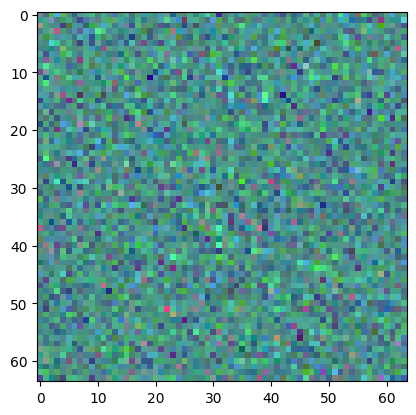

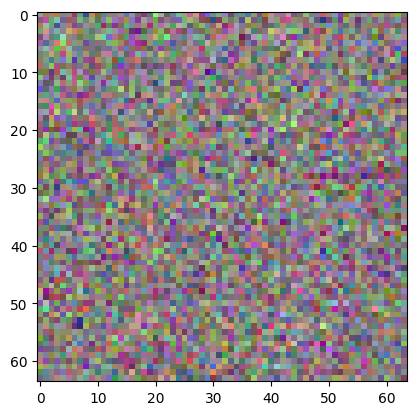

In [35]:
new, x_0 = trainer.model.sample_imgs(n_samples=1)
# min max scaling
new = new[0].cpu().numpy()
min_vals = np.reshape(np.min(new, axis=(1, 2)), (3, 1, 1))
max_vals = np.reshape(np.max(new, axis=(1, 2)), (3, 1, 1))
scaled_array = (new - min_vals) / (max_vals - min_vals)
# back to device
# scaled_array = torch.tensor(scaled_array, device=device)
# # add batch dimension
# scaled_array = scaled_array.unsqueeze(0)
# # decoded = vae.to_image(scaled_array)
# array = decoded[0].cpu().numpy()
# # min max scaling
# min_vals = np.reshape(np.min(array, axis=(1, 2)), (3, 1, 1))
# max_vals = np.reshape(np.max(array, axis=(1, 2)), (3, 1, 1))
# scaled_array = (array - min_vals) / (max_vals - min_vals)
plt.imshow(scaled_array.transpose(1, 2, 0))
plt.show()

# decoded = vae.to_image(x_0)
array = x_0[0].cpu().numpy()
# min max scaling
min_vals = np.reshape(np.min(array, axis=(1, 2)), (3, 1, 1))
max_vals = np.reshape(np.max(array, axis=(1, 2)), (3, 1, 1))
scaled_array = (array - min_vals) / (max_vals - min_vals)
plt.imshow(scaled_array.transpose(1, 2, 0))

plt.show()

In [42]:
new

tensor([[[[ 5.4612e+06,  1.8919e+08,  6.4927e+07,  ..., -9.6741e+06,
           -2.4170e+07, -2.1911e+08],
          [ 3.1939e+07, -2.5685e+07, -5.9083e+07,  ..., -7.8363e+07,
           -2.5110e+07, -9.6595e+06],
          [ 5.4600e+07,  4.5148e+07, -9.7505e+07,  ..., -3.0974e+07,
            6.1806e+07,  2.5133e+07],
          ...,
          [-7.0701e+07,  1.1547e+07, -2.4920e+07,  ...,  6.0378e+07,
           -3.8059e+07, -1.7523e+07],
          [ 1.4329e+08,  2.3330e+07, -9.4046e+05,  ..., -5.6867e+07,
           -6.0808e+07, -2.5506e+07],
          [ 8.0103e+07,  2.2205e+07,  1.6831e+07,  ..., -4.6445e+07,
           -5.1908e+07,  6.2476e+07]],

         [[-2.4775e+07, -7.1467e+07,  3.6678e+07,  ...,  5.3889e+07,
            3.5518e+07, -2.7456e+07],
          [ 3.3050e+07,  4.4145e+07, -6.4462e+07,  ...,  4.4266e+07,
            5.0183e+06, -4.1813e+07],
          [-4.7769e+07, -9.1070e+07, -8.3764e+07,  ..., -4.9554e+07,
            2.2069e+07,  2.6731e+07],
          ...,
     